In [1]:
import os
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt
import torch
from torch import nn,optim
from torchvision import transforms

/usr/lib/python3.8/site-packages/PIL/Image.py:988: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


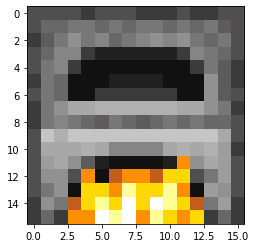

In [2]:
imgs = np.zeros((639,16,16,3))

for i in range(639):
    im = Image.open("block/"+str(i+1)+".png").convert('RGB')
    imgs[i]=np.asarray(im)
    im.close()
imgs = imgs.astype('uint8')
plt.imshow(imgs[253])

imgs = imgs.astype('float32') / 255

In [3]:
class Generative(nn.Module):
    def __init__(self):
        super(Generative, self).__init__()
        
        self.linear1 = nn.Linear(4096, 2048)
        self.linear2 = nn.Linear(2048, 1024)
        self.linear3 = nn.Linear(1024, 768)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,X):
        
        X = X.view(X.size(0),-1)
        
        X = self.relu(self.linear1(X))
        X = self.relu(self.linear2(X))
        X = self.sigmoid(self.linear3(X))
        
        return X

In [4]:
class Discriminative(nn.Module):
    def __init__(self):
        super(Discriminative, self).__init__()
        
        self.linear1 = nn.Linear(768, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, X):
        
        X = X.view(X.size(0), -1)
        
        X = self.relu(self.linear1(X))
        X = self.relu(self.linear2(X))
        X = self.sigmoid(self.linear3(X))
        
        return X

In [5]:
lr = 0.001

disc = Discriminative()
disc_optimizer = optim.Adam(params=disc.parameters(), lr=lr, betas=(0.5,.999))

loss = nn.BCELoss()

gen = Generative()
gen_optimizer = optim.Adam(params=gen.parameters(), lr=lr, betas=(0.5,.999))

n_epochs = 20

real_images = torch.from_numpy(imgs).view(639,768)

for e in range(n_epochs):
    disc_optimizer.zero_grad()
    
    # Define real_images, real_labels
    real_labels = torch.full((real_images.size(0),1), 1)
    # Generate noise and define fake_labels
    noise_vectors = torch.randn(real_images.size(0), 4096, 1, 1)
    fake_labels = torch.full((real_images.size(0),1), 0)
    
    # Train discriminative network one step using batch of real images
    output = disc(real_images)
    real_loss = loss(output, real_labels)
    real_loss.backward()
    disc_real_avg = output.mean().item()
    
    # Generate fake images from noise and pass them through disc. net.
    fake_images = gen(noise_vectors)
    output = disc(fake_images.detach())
    fake_loss = loss(output, fake_labels)
    fake_loss.backward()
    
    # Aggregative real and fake loss and update weights
    step_loss = real_loss + fake_loss
    disc_fake_avg = output.mean().item()
    disc_optimizer.step()
    
    # Train generative network
    gen_optimizer.zero_grad()

    output = disc(fake_images)
    gen_loss = loss(output, real_labels)
    gen_loss.backward()
    gen_avg = output.mean().item()
    gen_optimizer.step()
    
    if e % 1 == 0:
        print("Epoch: "+str(e+1)+" | Disc. Loss: "+str(step_loss.item())+" | Gen. Loss: "+str(gen_loss.item())+
         " | D(X): "+str(disc_real_avg)+" | D(G(Z)): "+str(disc_fake_avg)+" -> "+str(gen_avg))
    

Epoch: 1 | Disc. Loss: 1.3924212455749512 | Gen. Loss: 0.8250025510787964 | D(X): 0.47550326585769653 | D(G(Z)): 0.4774320721626282 -> 0.43823403120040894
Epoch: 2 | Disc. Loss: 1.4487431049346924 | Gen. Loss: 0.8132330179214478 | D(X): 0.453073650598526 | D(G(Z)): 0.48119062185287476 -> 0.4434232711791992
Epoch: 3 | Disc. Loss: 1.520831823348999 | Gen. Loss: 0.7754400372505188 | D(X): 0.4438760578632355 | D(G(Z)): 0.5067548155784607 -> 0.4605056643486023
Epoch: 4 | Disc. Loss: 1.5246433019638062 | Gen. Loss: 0.7848193049430847 | D(X): 0.44762706756591797 | D(G(Z)): 0.5128515958786011 -> 0.45620229840278625
Epoch: 5 | Disc. Loss: 1.4595448970794678 | Gen. Loss: 0.8085178136825562 | D(X): 0.45962998270988464 | D(G(Z)): 0.4940706193447113 -> 0.4455188512802124
Epoch: 6 | Disc. Loss: 1.394007921218872 | Gen. Loss: 0.8389976620674133 | D(X): 0.4814258813858032 | D(G(Z)): 0.4846200942993164 -> 0.4321524500846863
Epoch: 7 | Disc. Loss: 1.3416059017181396 | Gen. Loss: 0.8940683603286743 | D(X

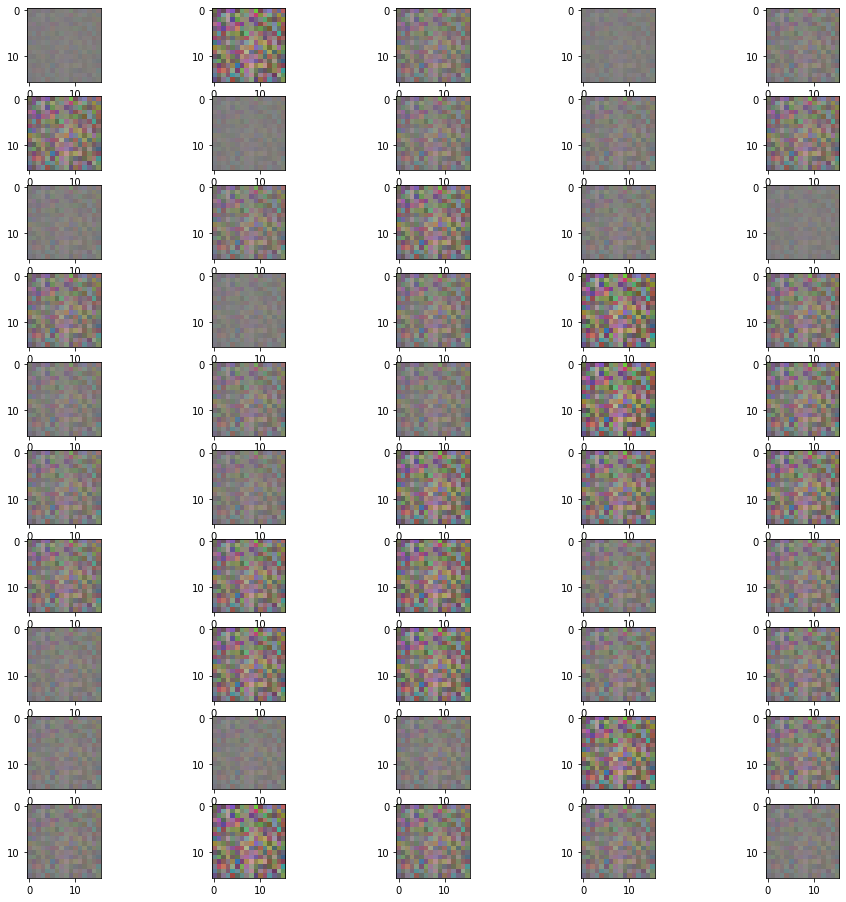

In [30]:
noise = torch.randn(500,4096,1,1)
p = gen(noise)
fig, axes = plt.subplots(10, 5, figsize=(16,16))

for i,im in enumerate(axes.flat):
    im.imshow(p[i].view(16,16,3).detach())
#print(disc(p[101].view(1,768)))

In [12]:
p.view(3,16,16).detach()*255

tensor([[[116.9863, 120.3865, 100.6834, 123.7160,  98.5700, 131.8343, 113.4654,
          102.2872, 108.6274, 144.5008, 113.7539, 148.2921, 128.1282, 106.9673,
          160.5053, 117.7284],
         [102.3661, 101.2107, 121.1936, 140.5934, 119.7221, 136.6992, 132.1259,
          109.7522, 140.7800, 120.1235, 130.6548, 117.9894, 166.2351,  92.6289,
          126.8637,  95.6034],
         [106.2934, 124.4929, 121.9807, 140.6969, 131.7872, 126.4375, 160.7753,
          138.8309, 119.3444, 113.0432, 115.1410, 118.0891, 140.4855, 157.7018,
          110.8100, 111.4310],
         [114.3656, 111.5466, 104.0526, 124.4096, 101.8265, 133.1991, 123.1394,
          144.9440, 145.8322, 155.8512, 143.0537, 135.9815, 114.4470, 130.1663,
          113.0034, 143.8371],
         [150.3400, 117.1606, 125.5082, 132.5305, 120.1422, 123.0922, 140.6982,
          131.9727, 146.9002, 120.2917, 133.4102, 164.3829,  93.1061, 121.9035,
          128.2805, 138.5353],
         [ 97.2946, 155.1549, 131.6357, 129.8